In [1]:
from frog.flow_reconstruction import FlowReconstruction
model = FlowReconstruction().load('../data/gp_model')

Keras model found but regressor has no `model` attribute.


In [2]:
from data_handler import dataHandler

X_variable=['p.txt', 'T.txt', 'M.txt']
y_variable=['Pressure', 'Temperature', 'Mach', 'Heat_Flux']


bc = dataHandler(
    '../data/Q1D.hdf5', 
    ['p0in', 'T0in'])

lfd = dataHandler(
    '../data/Q1D.hdf5', 
    X_variable)

hfd = dataHandler(
    '../data/SU2_fluid.hdf5',
    y_variable)

ntrain=145
nvalidation = ntrain+18
ntest = nvalidation+18

X_train = lfd.data[:,:ntrain].T
y_train = hfd.data[:,:ntrain].T
bc_train = bc.data[:,:ntrain].T

X_validation = lfd.data[:,ntrain:nvalidation].T
y_validation = hfd.data[:,ntrain:nvalidation].T
bc_validation = bc.data[:,ntrain:nvalidation].T

X_test = lfd.data[:,nvalidation:ntest].T
y_test = hfd.data[:,nvalidation:ntest].T
bc_test = bc.data[:,nvalidation:ntest].T

prediction = model.predict(X_test)

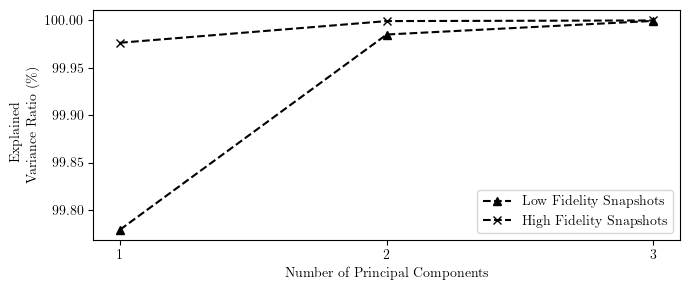

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.figure(figsize=(7, 3))
# exemplo: fig, ax = plt.subplots()
ax = plt.gca()  # pega o eixo atual
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

lf_energy = np.cumsum(model.X_rom.named_steps['reducer'].explained_variance_ratio_)*100
x = np.arange(1, len(lf_energy)+1)
ax.plot(x,lf_energy, 
    ls='--', marker='^', label='Low Fidelity Snapshots', color='k')
hf_energy = np.cumsum(model.y_rom.named_steps['reducer'].explained_variance_ratio_)*100

ax.plot(x, hf_energy,
    ls='--', marker='x', label='High Fidelity Snapshots', color='k')
ax.set_xlabel(r"Number of Principal Components")
ax.set_ylabel(r"Explained \\ Variance Ratio (\%)")
ax.set_xticks(x)
ax.legend()
ax.figure.tight_layout()
ax.figure.savefig("../latex_src/Figuras/POD_energy.pdf")

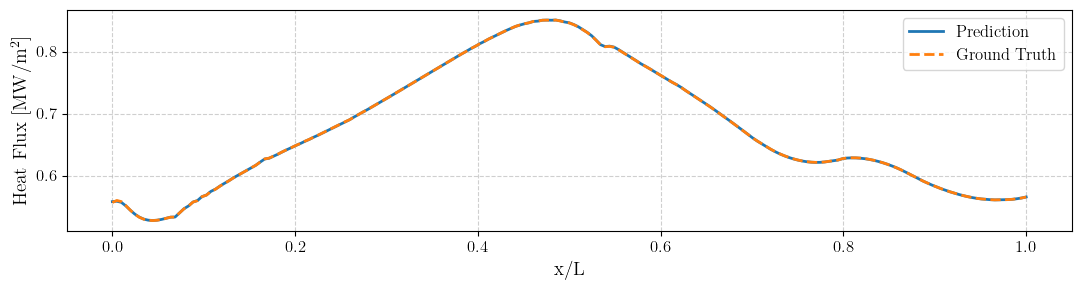

In [4]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.figure(figsize=(11,3))
idx = 4
x = np.linspace(0, 1, len(y_test[idx, hfd.indexes['Heat_Flux']][3:-2]))
# Plot prediction
plt.plot(x,prediction[idx, hfd.indexes['Heat_Flux']][3:-2]/1e6, label=r'Prediction', color='tab:blue', linewidth=2)

# Plot ground truth
plt.plot(x,y_test[idx, hfd.indexes['Heat_Flux']][3:-2]/1e6, label=r'Ground Truth', color='tab:orange', linewidth=2, linestyle='--')

# Title and labels with LaTeX
#plt.title(r'Comparison of Heat Flux: Prediction vs Ground Truth', fontsize=16, fontweight='bold')
plt.xlabel(r'x/L', fontsize=14)
plt.ylabel(r'Heat Flux [$\mathrm{MW/m^2}$]', fontsize=14)

# Grid and style
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig("../latex_src/Figuras/kriging_heat_flux.pdf", bbox_inches='tight')
plt.show()



In [5]:
def plot_ground_truth(mesh, vmin, vmax, sargs, variable):
    import pyvista as pv
    plotter = pv.Plotter(window_size=(800,600))
    plotter.add_mesh(mesh, scalars='Ground-Truth', cmap='plasma', clim=(vmin, vmax), scalar_bar_args=sargs)
    plotter.add_mesh(mesh.contour(), color="black")
    plotter.view_xy()
    plotter.camera.zoom(1.5)
    plotter.show()
    plotter.save_graphic(f"../latex_src/Figuras/kriging_ground_truth_{variable.lower()}.pdf")


def plot_rom(mesh, vmin, vmax, sargs, variable):
    import pyvista as pv
    plotter = pv.Plotter(window_size=(800,600))
    plotter.add_mesh(mesh, scalars='ROM', cmap='plasma', clim=(vmin, vmax), scalar_bar_args=sargs)
    plotter.add_mesh(mesh.contour(), color="black")
    plotter.view_xy()
    plotter.camera.zoom(1.5)
    plotter.show()
    plotter.save_graphic(f"../latex_src/Figuras/kriging_prediction_{variable.lower()}.pdf")



# def plot_error_log(mesh, vmin, vmax, sargs, variable):
#     import pyvista as pv
#     plotter = pv.Plotter(window_size=(800,600))
#     plotter.add_mesh(mesh, scalars='Relative Error Log', cmap='coolwarm', clim=(vmin, vmax), scalar_bar_args=sargs)
#     plotter.add_mesh(mesh.contour(), color="black")
#     plotter.view_xy()
#     plotter.camera.zoom(1.5)
#     plotter.show()
#     plotter.save_graphic(f"../latex_src/Figuras/kriging_error_{variable.lower()}.pdf")


def plot_relative_error(mesh, vmin, vmax, sargs, variable):
    import pyvista as pv
    plotter = pv.Plotter(window_size=(800,600))
    plotter.add_mesh(mesh, scalars='Relative Error (%)', cmap='coolwarm', clim=(vmin, vmax), scalar_bar_args=sargs)
    plotter.add_mesh(mesh.contour(), color="black")
    plotter.view_xy()
    plotter.camera.zoom(1.5)
    plotter.show()
    plotter.save_graphic(f"../latex_src/Figuras/kriging_error_{variable.lower()}.pdf")



def plot_var(idx, variable, unit, scale=1):
    import pyvista as pv
    import numpy as np

    pv.set_jupyter_backend('static')

    meshfile = '../data/sample_runs/SU2/outputs/fluid.vtk'
    mesh = pv.read(meshfile)

    mesh['Ground-Truth'] = y_test[idx, hfd.indexes[f'{variable}']] * scale
    mesh['ROM'] = prediction[idx, hfd.indexes[f'{variable}']] * scale

    eps = 1e-3
    rel_error = (mesh['ROM'] - mesh['Ground-Truth']) / (np.abs(mesh['Ground-Truth']) + 1e-12)* 100
    #mesh['Relative Error (%)'] = np.log10(rel_error + eps)
    mesh['Relative Error (%)'] = rel_error

    # vmin_err = mesh['Relative Error (%)'].min()
    # vmax_err = mesh['Relative Error (%)'].max()
    vmin_err = -0.33
    vmax_err = 0.94

    vmin_common = min(mesh['Ground-Truth'].min(), mesh['ROM'].min())
    vmax_common = max(mesh['Ground-Truth'].max(), mesh['ROM'].max())

    sargs_template = dict(
        height=0.1,
        vertical=False,
        position_x=0.25,
        position_y=0.02,
        title_font_size=18,
        label_font_size=14,
        fmt="%.2f",
        n_labels=5,
    )
    sargs_gt = dict(**sargs_template, title=f"{variable} - Ground Truth {unit}")
    sargs_rom = dict(**sargs_template, title=f"{variable} - ROM {unit}")
    sargs_err = dict(**sargs_template, title=f"{variable} - Relative Error (%)")

    mesh_gt = mesh.copy()
    mesh_rom = mesh.copy()
    mesh_err = mesh.copy()

    # Agora chama os plots separados, passando mesh, limites e args
    plot_ground_truth(mesh_gt, vmin_common, vmax_common, sargs_gt, variable)
    plot_rom(mesh_rom, vmin_common, vmax_common, sargs_rom, variable)
    plot_relative_error(mesh_err, vmin_err, vmax_err, sargs_err, variable)


In [10]:
def nrmse(y_true, y_pred):
    """Normalized Root Mean Squared Error"""
    mse = np.mean((y_true - y_pred) ** 2)
    norm = np.max(y_true) - np.min(y_true)
    return np.sqrt(mse) / norm if norm != 0 else np.nan * 100

def max_rel_error(y_true, y_pred):
    """Maximum relative error (absolute value)"""
    rel_err = np.abs((y_pred - y_true) / (np.abs(y_true) + 1e-12)) * 100
    return np.max(rel_err)

results = {}

for var in ['Pressure', 'Temperature', 'Mach', 'Heat_Flux']:
    idx_var = hfd.indexes[var]
    y_true = y_test[:, idx_var]
    y_pred = prediction[:, idx_var]
    nrmse_val = nrmse(y_true, y_pred)
    max_rel_val = max_rel_error(y_true, y_pred)
    results[var] = {'NRMSE': nrmse_val, 'MaxRelError': max_rel_val}

for var, metrics in results.items():
    print(f"{var}: NRMSE = {metrics['NRMSE']:.2e}, MaxRelError = {metrics['MaxRelError']:.2e}")

Pressure: NRMSE = 1.89e-06, MaxRelError = 2.43e-02
Temperature: NRMSE = 5.50e-05, MaxRelError = 3.95e-01
Mach: NRMSE = 4.24e-05, MaxRelError = 9.96e-01
Heat_Flux: NRMSE = 3.07e-04, MaxRelError = 5.60e+00


erros Kriging:
Training time: 5.70 seconds
Pressure: NRMSE = 1.89e-06, MaxRelError = 2.43e-02
Temperature: NRMSE = 5.50e-05, MaxRelError = 3.95e-01
Mach: NRMSE = 4.24e-05, MaxRelError = 9.96e-01
Heat_Flux: NRMSE = 3.07e-04, MaxRelError = 5.60e+00

erros NN:
Training time: 317.33 seconds
Pressure: NRMSE = 2.08e-06, MaxRelError = 2.48e-02
Temperature: NRMSE = 2.12e-03, MaxRelError = 5.70e-01
Mach: NRMSE = 5.77e-05, MaxRelError = 1.06e+00
Heat_Flux: NRMSE = 1.28e-03, MaxRelError = 5.97e+00


\begin{table}[H]
\centering
\caption{Computational cost and accuracy comparison. The table shows the CPU time for training and a single evaluation, the speedup relative to the high-fidelity model, and the Normalized Root Mean Squared Error for reconstructed Temperature (NRMSE-T) and wall heat flux (NRMSE-q) for the test dataset \citep{moreira2023}.}
\label{tab:cost_accuracy_comparison}
\begin{tabular}{lcccc}
\toprule
 & CPU time & speedup & NRMSE-T & NRMSE-q \\
\midrule
\textbf{high-fidelity model} & 1,532.42 seconds & - & - & - \\
\textbf{low-fidelity model} & 1.02 seconds & 1,502.37 x & - & - \\
\textbf{NN training} & 231.14 seconds & - & - & - \\
\textbf{Kriging training} & 1.63 seconds & - & - & - \\
\textbf{single NN evaluation} & 0.23 seconds & 6,662.70 x & 1.38\% & 1.55\% \\
\textbf{single Kriging evaluation} & 0.04 seconds & 38,310.50 x & 0.01\% & 0.04\% \\
\bottomrule
\end{tabular}
\end{table}


In [13]:
bc_test[4]

array([1.19100000e+06, 9.26699625e+02])

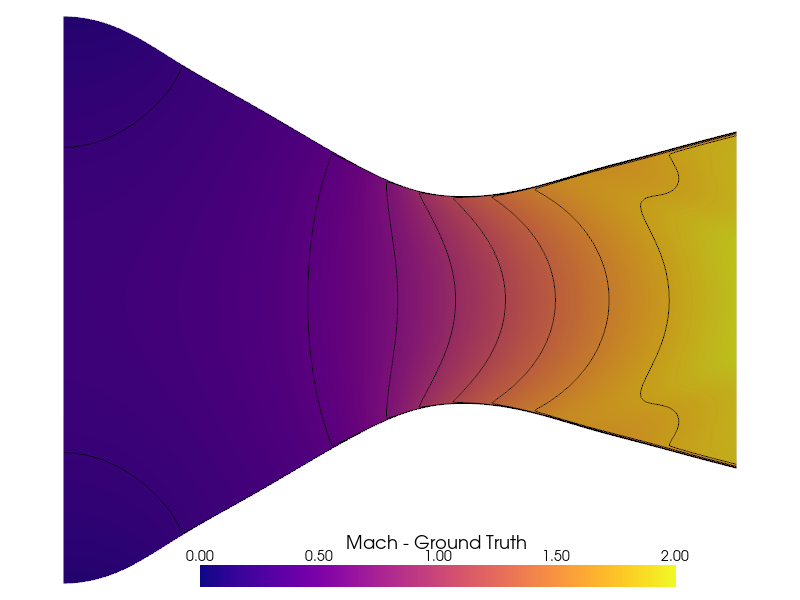

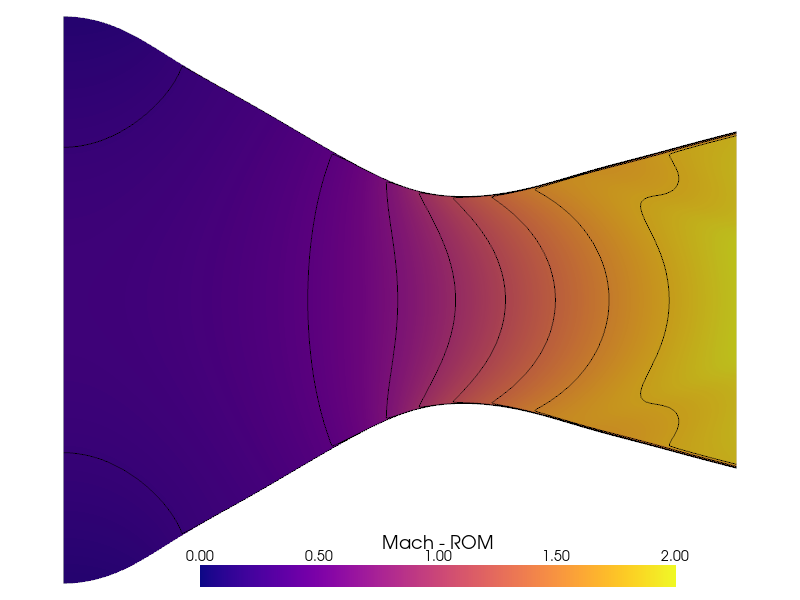

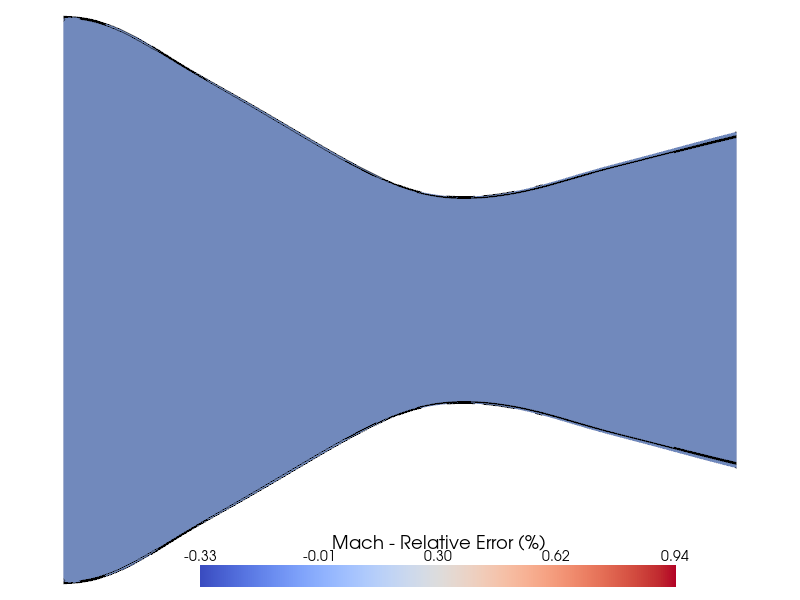

In [7]:
plot_var(4, 'Mach', '')

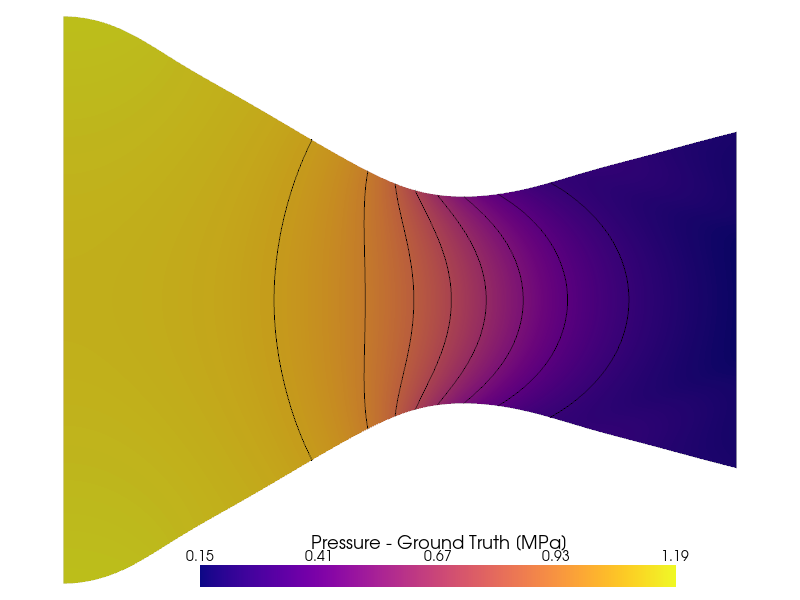

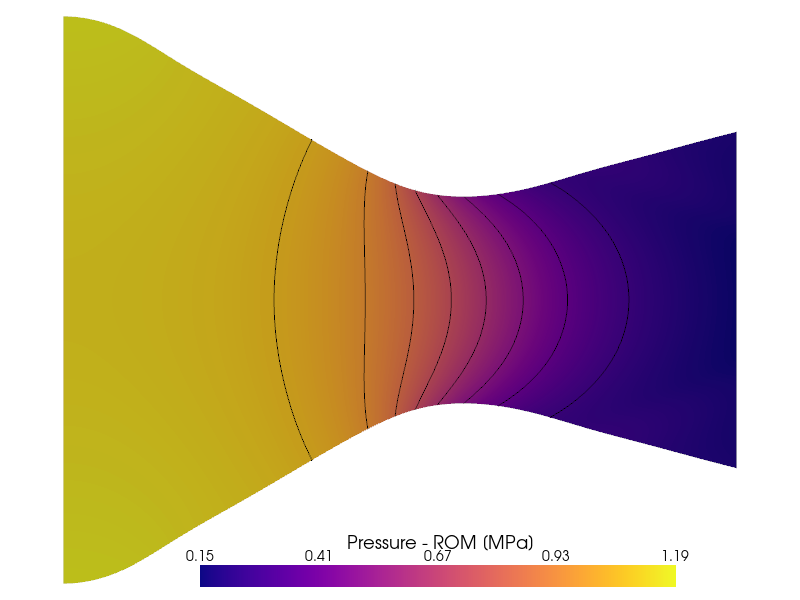

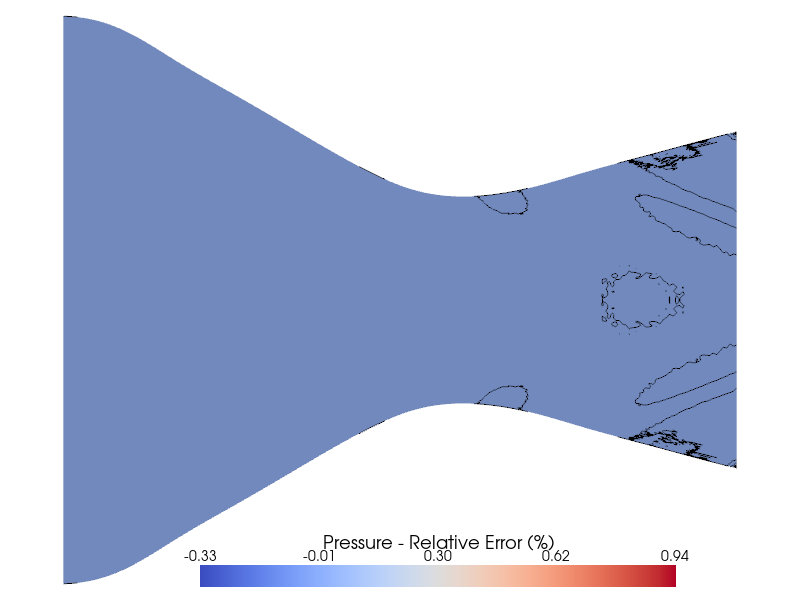

In [8]:
plot_var(4, 'Pressure', '[MPa]', scale=1e-6)

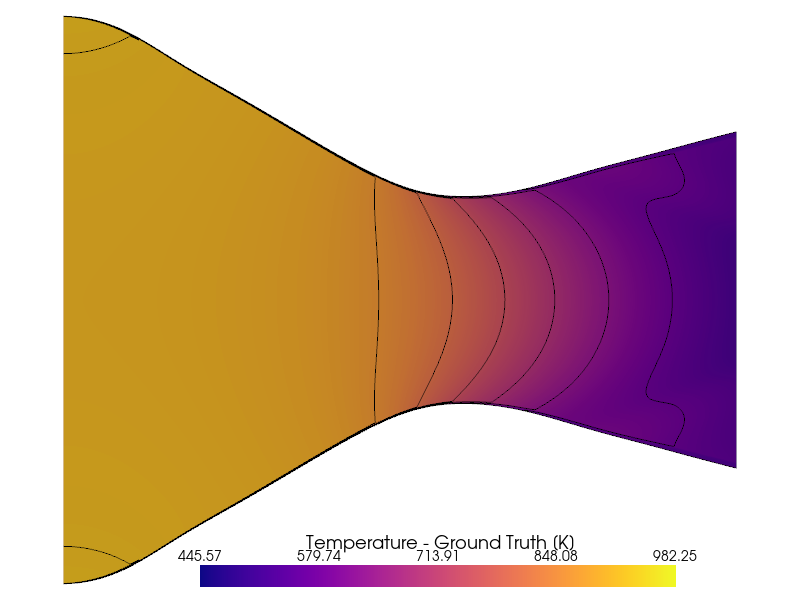

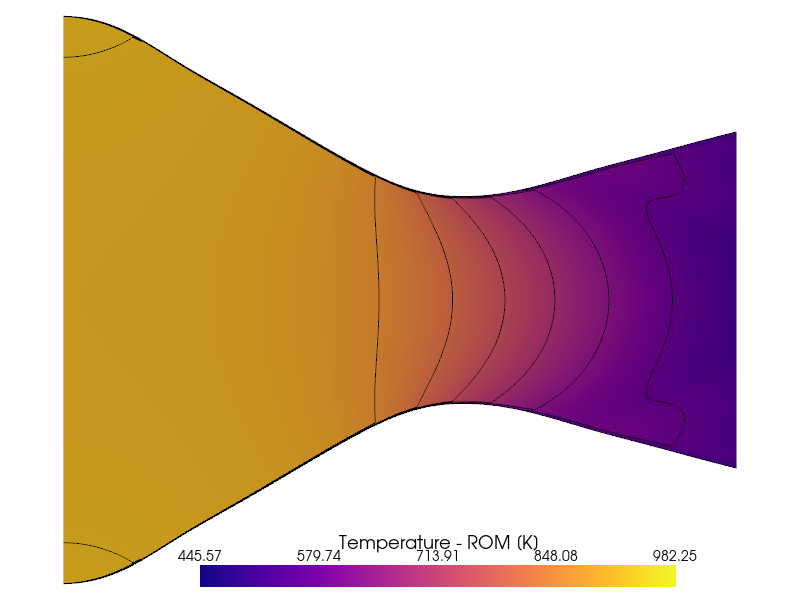

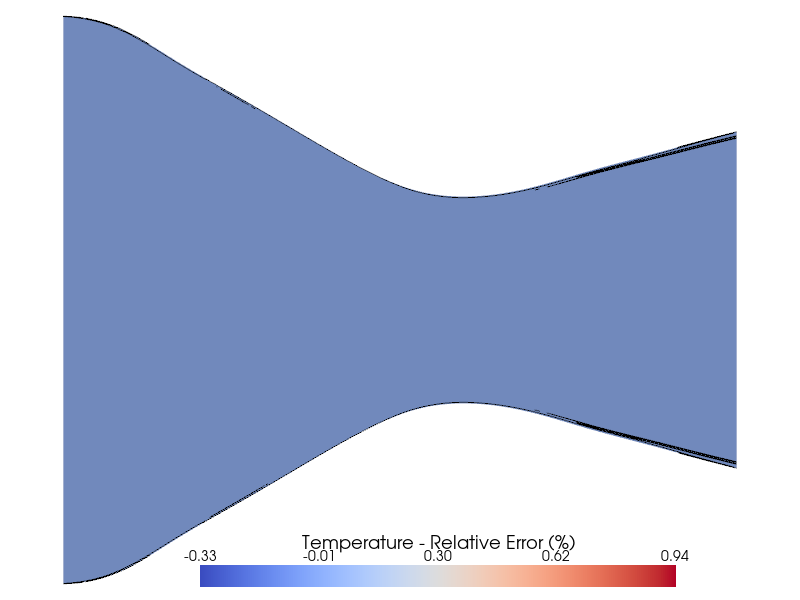

In [9]:
plot_var(4, 'Temperature', '[K]')